# GitHub timeline

Using the GraphQL API as the REST/Python API only goes back 90 days.

In [33]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
# from github import Github
from collections import Counter
import requests, os, datetime
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# 1) Personal access token from GitHub
TOKEN = os.getenv('GITHUB_API_TOKEN')

# 2) GitHub GraphQL endpoint
GITHUB_GRAPHQL_URL = "https://api.github.com/graphql"

# 3) Prepare headers (use "Bearer" not "token")
headers = {
    "Authorization": f"Bearer {TOKEN}",
    "Content-Type": "application/json"
}

# 4) Define the date range: one year ago to today (UTC)
today = datetime.datetime.now(datetime.timezone.utc)
one_year_ago = today - datetime.timedelta(days=365)

# 5) Write your GraphQL query
# This query grabs the user’s contributionsCollection between 'fromDate' and 'toDate'.
query = """
query($userLogin: String!, $fromDate: DateTime!, $toDate: DateTime!) {
  user(login: $userLogin) {
    contributionsCollection(from: $fromDate, to: $toDate) {
      contributionCalendar {
        totalContributions
        weeks {
          contributionDays {
            date
            contributionCount
          }
        }
      }
    }
  }
}
"""

# 6) Define query variables
variables = {
    "userLogin": "yanndebray",               # The GitHub username you want to query
    "fromDate": one_year_ago.isoformat(),    # Convert to ISO 8601, e.g. "2024-02-02T12:34:56+00:00"
    "toDate": today.isoformat()              # Convert to ISO 8601
}

# 7) Make the POST request to GitHub’s GraphQL endpoint
resp = requests.post(
    GITHUB_GRAPHQL_URL,
    headers=headers,
    json={"query": query, "variables": variables},
)

# 8) Parse the JSON response
data = resp.json()

# 9) Handle possible errors or unexpected data
if "errors" in data:
    print("Errors returned by the API:", data["errors"])
elif "data" in data:
    # Extract the contribution calendar data
    cal = data["data"]["user"]["contributionsCollection"]["contributionCalendar"]
    total = cal["totalContributions"]
    print("Total contributions in the last year =", total)
    
    # Loop over each week and each day to show daily counts
    for week in cal["weeks"]:
        for day in week["contributionDays"]:
            print(f"{day['date']}: {day['contributionCount']}")
else:
    print("Unexpected response format:", data)


Total contributions in the last year = 352
2024-02-04: 0
2024-02-05: 0
2024-02-06: 0
2024-02-07: 2
2024-02-08: 0
2024-02-09: 0
2024-02-10: 0
2024-02-11: 0
2024-02-12: 0
2024-02-13: 0
2024-02-14: 0
2024-02-15: 0
2024-02-16: 0
2024-02-17: 0
2024-02-18: 0
2024-02-19: 0
2024-02-20: 0
2024-02-21: 0
2024-02-22: 0
2024-02-23: 0
2024-02-24: 0
2024-02-25: 0
2024-02-26: 0
2024-02-27: 0
2024-02-28: 0
2024-02-29: 0
2024-03-01: 0
2024-03-02: 0
2024-03-03: 0
2024-03-04: 0
2024-03-05: 0
2024-03-06: 2
2024-03-07: 0
2024-03-08: 0
2024-03-09: 0
2024-03-10: 0
2024-03-11: 3
2024-03-12: 0
2024-03-13: 0
2024-03-14: 0
2024-03-15: 0
2024-03-16: 0
2024-03-17: 0
2024-03-18: 0
2024-03-19: 0
2024-03-20: 0
2024-03-21: 0
2024-03-22: 0
2024-03-23: 0
2024-03-24: 0
2024-03-25: 0
2024-03-26: 0
2024-03-27: 0
2024-03-28: 0
2024-03-29: 0
2024-03-30: 0
2024-03-31: 0
2024-04-01: 0
2024-04-02: 0
2024-04-03: 2
2024-04-04: 0
2024-04-05: 5
2024-04-06: 0
2024-04-07: 0
2024-04-08: 3
2024-04-09: 0
2024-04-10: 2
2024-04-11: 0
2024-

In [32]:
cal['weeks'][0]['contributionDays']

[{'date': '2024-02-04', 'contributionCount': 0},
 {'date': '2024-02-05', 'contributionCount': 0},
 {'date': '2024-02-06', 'contributionCount': 0},
 {'date': '2024-02-07', 'contributionCount': 2},
 {'date': '2024-02-08', 'contributionCount': 0},
 {'date': '2024-02-09', 'contributionCount': 0},
 {'date': '2024-02-10', 'contributionCount': 0}]

In [21]:
import pandas as pd

# Extract the contribution days from the calendar
contribution_days = []
for week in cal['weeks']:
    for day in week['contributionDays']:
        contribution_days.append(day)

# Create a DataFrame from the contribution days
df_contributions = pd.DataFrame(contribution_days)

print(df_contributions)

           date  contributionCount
0    2024-02-04                  0
1    2024-02-05                  0
2    2024-02-06                  0
3    2024-02-07                  2
4    2024-02-08                  0
..          ...                ...
360  2025-01-29                  0
361  2025-01-30                  0
362  2025-01-31                  2
363  2025-02-01                  0
364  2025-02-02                  7

[365 rows x 2 columns]


Total contributions in the last year: 352


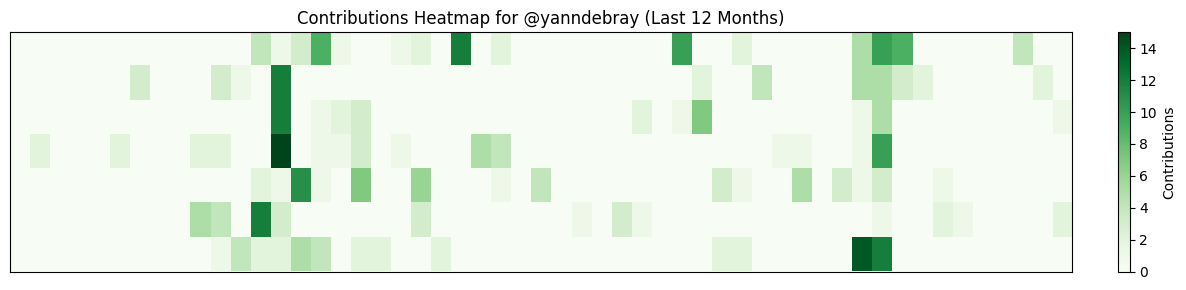

In [35]:

# 6) Parse the returned contribution data into a daily dictionary
cal = data["data"]["user"]["contributionsCollection"]["contributionCalendar"]
print("Total contributions in the last year:", cal["totalContributions"])

daily_counts = {}
for week in cal["weeks"]:
    for day_info in week["contributionDays"]:
        # day_info["date"] is e.g. "2024-01-31"
        dt = datetime.datetime.fromisoformat(day_info["date"]).date()
        daily_counts[dt] = day_info["contributionCount"]

# 7) Build a 7×53 grid (row=day of week, col=week)
#    - We’ll anchor the start_date to the Sunday before (or on) 'one_year_ago'
start_date = one_year_ago.date()
# Move backward until we hit Sunday
while start_date.weekday() != 6:  # Sunday = 6 in Python's weekday()
    start_date -= datetime.timedelta(days=1)

# Initialize a 7 (rows) x 53 (columns) array
heatmap = np.zeros((7, 53), dtype=int)

current_date = start_date
max_cols = 53

for col in range(max_cols):
    for row in range(7):
        # If we've gone past 'today' (beyond the desired range), break
        if current_date > today.date():
            break

        # Fill with contribution count (default 0 if missing)
        heatmap[row, col] = daily_counts.get(current_date, 0)

        current_date += datetime.timedelta(days=1)

    if current_date > today.date():
        break

# 8) Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 3))

# GitHub-like approach often puts Sunday on top, so let’s flip it:
# Right now, row=0 is Sunday at the *top* of the array, 
# but Python's default for imshow puts row=0 at the top as well.
# So if you want Sunday on top visually, you can do no flip. 
# If you want Monday on top, you can reorder. For simplicity:
image_data = heatmap  # or np.flipud(heatmap) if you prefer flipping rows

# Display the grid with a "Greens" colormap
im = ax.imshow(
    image_data, 
    cmap="Greens", 
    aspect="auto", 
    interpolation="nearest"
)

ax.set_title("Contributions Heatmap for @yanndebray (Last 12 Months)")
ax.set_xticks([])
ax.set_yticks([])

# Optionally add a colorbar for scale
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.04, label="Contributions")

plt.tight_layout()
plt.show()
